<a href="https://colab.research.google.com/github/NatSy77/projet_7/blob/main/P7_modelisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implémentez un modèle de scoring #modelisetion

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


## Importation

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
!pip install mlflow

In [4]:
!pip install lightgbm

In [5]:
#!pip install --upgrade threadpoolctl scikit-learn imbalanced-learn xgboost

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# List files available
print(os.listdir("/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/"))

['app_train.csv', 'app_test.csv']


In [8]:
#importation fichier
app_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 242)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,False,False,False,False,True,False,True,False,1,False
1,1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,False,False,False,False,False,False,True,False,0,False
2,2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,False,False,False,False,False,False,False,False,0,False
3,3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,False,False,False,False,False,False,False,False,0,False
4,4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,False,False,False,False,False,False,False,False,0,False


In [9]:
# Testing data features
app_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DS_projet_7/data_modelisation/app_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 241)


,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0,100001,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,False,False,False,False,False,True,False,True,False,False
1,1,100005,0,0,1,0,99000.0,222768.0,17370.0,180000.0,...,False,False,False,False,False,False,False,False,False,False
2,2,100013,0,1,1,0,202500.0,663264.0,69777.0,630000.0,...,False,False,False,False,False,False,False,False,False,False
3,3,100028,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,False,False,False,False,True,False,False,True,False,False
4,4,100038,0,1,0,1,180000.0,625500.0,32067.0,625500.0,...,False,False,False,False,False,False,False,False,False,False


## Exploration

In [10]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


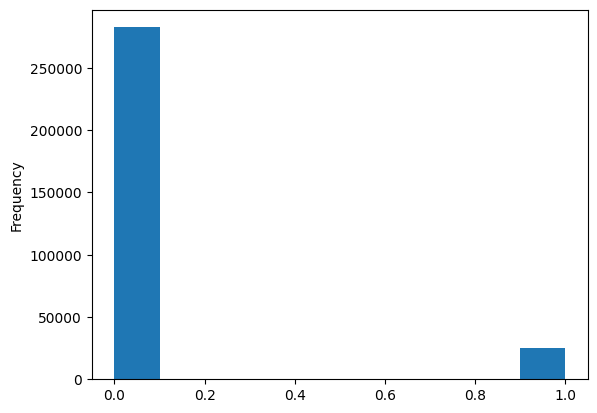

In [11]:
app_train['TARGET'].astype(int).plot.hist();

In [12]:
# Number of each type of column
app_train.dtypes.value_counts()

,count
bool,132
float64,66
int64,44


In [13]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 242)
Testing Features shape:  (48744, 241)


# Modélisation

### Préparation de l'environement

In [14]:
!pip install mlflow pyngrok

In [15]:
import os
from pyngrok import ngrok
import mlflow
import mlflow.sklearn  # Pour enregistrer les modèles scikit-learn

In [16]:
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

### Chargement des données et préparation

In [17]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Chargement des données
if 'TARGET' in app_train.columns:
    train = app_train.drop(columns=['TARGET'])
    target = app_train['TARGET']
else:
    train = app_train.copy()
    target = None

# Vérification des valeurs manquantes
if train.isnull().sum().sum() > 0:
    imputer = SimpleImputer(strategy='median')
    train = imputer.fit_transform(train)
else:
    train = train.values  # Conversion explicite si c'est un DataFrame

# Mise à l'échelle des caractéristiques
scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)

# Diviser les données en ensembles d'entraînement et de test (si `target` est défini)
if target is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        train, target, test_size=0.2, random_state=42
    )
else:
    X_train, X_test, y_train, y_test = None, None, None, None
    print("Attention : Aucune étiquette ('target') n'a été fournie.")

# Appliquer les mêmes transformations sur les données de test
# (Utilisez les mêmes imputer et scaler, ajustés sur `train`)
app_test = app_test.drop(columns=['TARGET'], errors='ignore')  # Enlever la colonne TARGET si elle existe
app_test = imputer.transform(app_test)
app_test = scaler.transform(app_test)

### Initialisation de MLflow

In [18]:
import mlflow
import os

# Créer le répertoire mlflow s'il n'existe pas
mlflow_directory = "/content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow"
os.makedirs(mlflow_directory, exist_ok=True)

# Définir l'URI de suivi MLflow
mlflow.set_tracking_uri(f"file://{mlflow_directory}")

# Définir l'expérience
mlflow.set_experiment("Multi-Model Experiment lightgbm score metier")

#Model Experiment 3 LightGBM
#Multi-Model Experiment 2 class_weight='balanced'
#Multi-Model Experiment 1 SMOTE

2025/01/26 17:27:20 INFO mlflow.tracking.fluent: Experiment with name 'Multi-Model Experiment lightgbm score metier' does not exist. Creating a new experiment.


<Experiment: artifact_location=('file:///content/drive/MyDrive/Colab '
 'Notebooks/DS_projet_7/mlflow/706359919036996243'), creation_time=1737912440232, experiment_id='706359919036996243', last_update_time=1737912440232, lifecycle_stage='active', name='Multi-Model Experiment lightgbm score metier', tags={}>

In [19]:
input_example = np.array([X_train[1]])  # Exemple basé sur une ligne des données d'entraînement

### Préparation des outils et des données
Cette première étape configure les outils nécessaires, notamment pour gérer les classes déséquilibrées avec SMOTE et pour normaliser les données.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer

# Gérer les classes déséquilibrées avec SMOTE
#smote = SMOTE(random_state=42)
#X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalisation des données
scaler = MinMaxScaler()
# Ajuster le scaler à vos données d'entraînement (X_train ou X_train_resampled si vous utilisez SMOTE)
X_train = scaler.fit_transform(X_train) # ajustement du scaler aux données d'entraînement
# X_train_resampled = scaler.fit_transform(X_train_resampled) # si vous utilisez SMOTE, ajustez aux données rééchantillonnées
X_test = scaler.transform(X_test)

### Ajout d’une pipeline et Optimisation des hyperparamètres
Créer une pipeline pour standardiser le traitement, incluant SMOTE, la normalisation, et le modèle.

Intégration de RandomizedSearchCV pour trouver les meilleurs hyperparamètres d’un modèle dans une pipeline.

In [21]:
import time
import joblib
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from mlflow.sklearn import load_model, log_model
from joblib import Parallel, delayed
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

#### hyperparamètres

In [24]:
# Calculer la proportion des classes
from collections import Counter

In [26]:
# Dictionnaire des modèles avec leurs hyperparamètres
models_with_params = {

    # experimentation 3 param augmenté
    "LightGBM": {
        "model": LGBMClassifier(random_state=42, is_unbalance=True),
        "params": {
            'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'model__n_estimators': [50, 100, 200, 300],
            'model__max_depth': [3, 5, 7, 10],
            'model__num_leaves': [20, 31, 50, 70],
            'model__min_child_samples': [10, 20, 50, 100],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__min_split_gain': [0.0, 0.1, 0.2],
            'model__lambda_l1': [0.0, 0.1, 1.0],
            'model__lambda_l2': [0.0, 0.1, 1.0],
            'model__scale_pos_weight': [1, y_train_negative / y_train_positive] # Calcul du poids des classes
        }
    }
}

In [25]:
class_counts = Counter(y_train)  # Compte des classes
y_train_negative = class_counts[0]  # Classe négative (étiquetée comme 0)
y_train_positive = class_counts[1]  # Classe positive (étiquetée comme 1)

Hyperparamètres sélectionnés :

learning_rate: Contrôler la vitesse d'apprentissage.
n_estimators: Nombre total d'arbres.
max_depth: Limite la profondeur des arbres.
num_leaves: Contrôle la complexité de chaque arbre.
min_child_samples: Minimum d'exemples requis dans une feuille pour éviter le surapprentissage.
Gestion du déséquilibre des classes :

is_unbalance=True: Active une gestion automatique des classes déséquilibrées.
Si besoin, vous pouvez utiliser scale_pos_weightcomme alternative pour ajuster le poids des classes.

#### score métier

In [28]:
def custom_cost_function(y_true, y_pred, cost_fn=10, cost_fp=1):
    """
    Calcul d'un score métier basé sur le coût des erreurs.

    Args:
    y_true (array-like): Valeurs réelles.
    y_pred (array-like): Prédictions du modèle.
    cost_fn (int): Coût d'un faux négatif.
    cost_fp (int): Coût d'un faux positif.

    Returns:
    float: Coût total des erreurs.
    """
    # Matrice de confusion
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Calcul du coût total
    total_cost = (cost_fp * fp) + (cost_fn * fn)
    return total_cost

#### RandomizedSearchCV

In [29]:
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [30]:
# experimentation 3 param augmenté
def train_pipeline(model_name, model, params, X_train, y_train):
    print(f"\nEntraînement du pipeline pour {model_name}...")

    # Calculer les poids d'échantillons pour gérer le déséquilibre des classes
    sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

    # Création du pipeline
    pipeline = ImbPipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler()),
        ('model', model)
    ])

    # Initialisation de RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=pipeline,
        param_distributions=params,
        n_iter=20,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        random_state=42
    )

    try:
        # Entraîner le modèle en passant les poids d'échantillons
        random_search.fit(X_train, y_train, model__sample_weight=sample_weight)

        # Sauvegarde du meilleur modèle
        joblib.dump(random_search.best_estimator_, f'pipeline_{model_name}.pkl')
        print(f"Pipeline pour {model_name} sauvegardé sous le nom pipeline_{model_name}.pkl")

        # Sauvegarder les résultats de recherche
        results_df = pd.DataFrame(random_search.cv_results_)
        results_df.to_csv(f'results_{model_name}.csv', index=False)
        print(f"Résultats sauvegardés dans results_{model_name}.csv")

        return random_search.best_params_

    except Exception as e:
        print(f"Erreur lors de l'entraînement du pipeline pour {model_name} : {e}")
        return None

#### training

In [31]:
if __name__ == "__main__":
    # Vérifier si les données sont disponibles et ont une forme correcte
    if X_train is not None and y_train is not None:
        if X_train.shape[0] != y_train.shape[0]:
            print("Erreur : Le nombre d'exemples dans X_train et y_train ne correspond pas.")
        else:
            results = {}

            # Parcourir les modèles du dictionnaire et les entraîner un par un
            for model_name, model_data in models_with_params.items():
                print(f"\nEntraînement du modèle : {model_name}")

                try:
                    # Entraîner le modèle et récupérer les meilleurs hyperparamètres
                    best_params = train_pipeline(
                        model_name=model_name,
                        model=model_data["model"],
                        params=model_data["params"],
                        X_train=X_train,
                        y_train=y_train
                    )

                    results[model_name] = best_params
                    print(f"Meilleurs paramètres pour {model_name} : {best_params}")
                except Exception as e:
                    print(f"Erreur lors de l'entraînement de {model_name} : {e}")

            # Afficher les résultats finaux
            print("\nRésultats finaux :")
            for model, params in results.items():
                print(f"{model}: {params}")
    else:
        print("Erreur : Les données d'entraînement ne sont pas disponibles.")


Entraînement du modèle : LightGBM

Entraînement du pipeline pour LightGBM...
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.231708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11943
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 223
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[

### Boucle sur plusieurs modèles avec journalisation MLflow
Cette étape inclut les modèles supplémentaires et enregistre chaque expérimentation dans MLflow.

In [32]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import shap
import gc

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
import sklearn
print(f"scikit-learn version: {sklearn.__version__}")

scikit-learn version: 1.6.1


In [35]:
# Liste des modèles
models = {
    "LightGBM": LGBMClassifier(random_state=42, is_unbalance=True)  # Paramètre pour gérer les classes déséquilibrées
}

In [36]:
# Liste pour stocker les courbes ROC
roc_curves = []

In [37]:
# Répertoire pour les sorties
output_dir = "mlflow_outputs"
os.makedirs(output_dir, exist_ok=True)

In [38]:
# Boucle sur chaque modèle
for model_name, model in models.items():
    start_time = time.time()

    try:
        # === Définir la pipeline ===
        pipeline = ImbPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler()),
            ('model', model)
        ])

        # === Entraîner la pipeline ===
        pipeline.fit(X_train, y_train)

        # Sauvegarder la pipeline localement
        pipeline_path = os.path.join(output_dir, f'pipeline_{model_name}.pkl')
        joblib.dump(pipeline, pipeline_path)

        # === Prédictions ===
        y_pred = pipeline.predict(X_test)
        y_prob = pipeline.predict_proba(X_test)[:, 1] if hasattr(pipeline, "predict_proba") else None

        # === Calcul des métriques ===
        total_cost = custom_cost_function(y_test, y_pred, cost_fn=10, cost_fp=1)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        auc_roc = roc_auc_score(y_test, y_prob) if y_prob is not None else None

        # === Ajustement du seuil pour minimiser le coût personnalisé ===
        optimal_threshold = None
        if y_prob is not None:
            thresholds = np.arange(0.1, 1.0, 0.05)
            costs = []

            for threshold in thresholds:
                y_pred_class = (y_prob >= threshold).astype(int)
                cost = custom_cost_function(y_test, y_pred_class, cost_fn=10, cost_fp=1)
                costs.append(cost)

            optimal_threshold = thresholds[np.argmin(costs)]
            print(f"Optimal Threshold: {optimal_threshold}")

        # === MLflow : Enregistrement ===
        with mlflow.start_run(run_name=model_name):
            # Paramètres du modèle
            mlflow.log_param("model_name", model_name)

            # Enregistrer les meilleurs hyperparamètres
            if isinstance(model, RandomizedSearchCV):
                best_params = model.best_params_
                for param_name, param_value in best_params.items():
                    mlflow.log_param(param_name, param_value)
            else:
                # En cas de modèle simple (sans recherche hyperparamétrique)
                if hasattr(model, "n_estimators"):
                    mlflow.log_param("n_estimators", model.n_estimators)
                if hasattr(model, "max_depth"):
                    mlflow.log_param("max_depth", model.max_depth)
                if hasattr(model, "learning_rate"):
                    mlflow.log_param("learning_rate", model.learning_rate)

            # Enregistrer les métriques
            mlflow.log_metric("custom_cost", total_cost)
            mlflow.log_metric("accuracy", accuracy)
            mlflow.log_metric("f1_score", f1)
            mlflow.log_metric("precision", precision)
            mlflow.log_metric("recall", recall)
            if auc_roc is not None:
                mlflow.log_metric("auc_roc", auc_roc)

            # Enregistrer le seuil optimal
            if optimal_threshold is not None:
                mlflow.log_param("optimal_threshold", optimal_threshold)

            # Enregistrer le pipeline complet
            joblib.dump(model, f'{model_name}_pipeline.pkl')
            mlflow.log_artifact(f'{model_name}_pipeline.pkl')

            # Journaliser la pipeline dans MLflow
            input_example = pd.DataFrame(X_train[:1])  # Exemple d'entrée pour le modèle
            log_model(
                sk_model=pipeline,
                artifact_path="model_pipeline",
                input_example=input_example
            )

            # === Courbe ROC ===
            if y_prob is not None:
                plt.figure()
                fpr, tpr, _ = roc_curve(y_test, y_prob)
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.title(f'ROC Curve - {model_name}')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.legend(loc="lower right")
                roc_curve_path = os.path.join(output_dir, f"roc_curve_{model_name}.png")
                plt.savefig(roc_curve_path)
                plt.close()
                mlflow.log_artifact(roc_curve_path)

            # Enregistrer le temps d'exécution
            elapsed_time = time.time() - start_time
            mlflow.log_metric("training_time", elapsed_time)

        print(f"Modèle {model_name} journalisé avec succès.")
    except Exception as e:
        print(f"Erreur lors de l'entraînement du modèle {model_name}: {e}")

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11963
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 233
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606
Optimal Threshold: 0.5500000000000002
Modèle LightGBM journalisé avec succès.


### Lancer l'interface MLflow UI
Utilisation d'une interface web distante via ngrok(exposée au public), créer un compte et récupérer le token

In [39]:
!ngrok authtoken 2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [42]:
!mlflow ui --backend-store-uri "file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow" --port 5000 &

[2025-01-26 18:03:08 +0000] [41954] [INFO] Starting gunicorn 23.0.0
[2025-01-26 18:03:08 +0000] [41954] [INFO] Listening at: http://127.0.0.1:5000 (41954)
[2025-01-26 18:03:08 +0000] [41954] [INFO] Using worker: sync
[2025-01-26 18:03:08 +0000] [41955] [INFO] Booting worker with pid: 41955
[2025-01-26 18:03:08 +0000] [41956] [INFO] Booting worker with pid: 41956
[2025-01-26 18:03:08 +0000] [41957] [INFO] Booting worker with pid: 41957
[2025-01-26 18:03:08 +0000] [41958] [INFO] Booting worker with pid: 41958
[2025-01-26 18:21:05 +0000] [41954] [INFO] Handling signal: int
[2025-01-26 18:21:05 +0000] [41955] [INFO] Worker exiting (pid: 41955)
[2025-01-26 18:21:05 +0000] [41956] [INFO] Worker exiting (pid: 41956)
[2025-01-26 18:21:05 +0000] [41958] [INFO] Worker exiting (pid: 41958)
[2025-01-26 18:21:05 +0000] [41957] [INFO] Worker exiting (pid: 41957)
[2025-01-26 18:21:06 +0000] [41954] [INFO] Shutting down: Master


In [41]:
from pyngrok import conf, ngrok

# Définir le token dans la configuration
conf.get_default().auth_token = "2qlJq50YUC2X62MFA1q7qxbILkY_5Dx45MFSwjmUQLvcqSHBU"

# Démarrer le tunnel
public_url = ngrok.connect(5000)
print(f"Interface MLflow accessible à : {public_url}")

Interface MLflow accessible à : NgrokTunnel: "https://af0b-34-80-211-37.ngrok-free.app" -> "http://localhost:5000"


In [41]:
# arrêter le tunnel ngrok
#ngrok.disconnect(public_url)

In [43]:
# URI du modèle
model_uri = "runs:/ade1fabf29c549f4b76aa509f4391391/model_pipeline"

# Charger le modèle
pyfunc_model = mlflow.pyfunc.load_model(model_uri)

In [ ]:
# adresss local du modele
# file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/589125752895295283/ade1fabf29c549f4b76aa509f4391391/artifacts/LightGBM_pipeline.pkl

Metriques :
- **F1-Score**
Le F1-score est une métrique qui combine précision et rappel en un seul score harmonique. C'est utile lorsque vous avez un déséquilibre entre les classes, car il pénalise les modèles qui sacrifient l'une au profit de l'autre.

Utilisé lorsque les faux positifs (FP) et faux négatifs (FN) sont également importants.

- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristic)**
L'AUC-ROC mesure la capacité d'un modèle à discriminer entre les classes positives et négatives, en testant différents seuils de probabilité.
Interprétation de l'AUC :
AUC = 1 : Parfaite séparation des classes.
AUC = 0.5 : Modèle aléatoire (aucune capacité de discrimination).
AUC < 0.5 : Mauvais modèle (inversion des classes).

Utile pour comparer des modèles indépendamment d'un seuil spécifique.

- **Précision (Precision)**
La précision mesure la proportion de vrais positifs parmi tous les échantillons prédits comme positifs.

Utile lorsque les faux positifs sont coûteux.

- **Rappel (Recall ou Sensibilité)**
Le rappel mesure la proportion de vrais positifs parmi tous les échantillons qui sont effectivement positifs.

- **Temps de calcul**
mesurer le temps de calcul de chaque modèle

Utile lorsque les faux négatifs sont coûteux.

Précision vs Rappel : Il existe souvent un compromis entre précision et rappel. Une augmentation de l'un peut réduire l'autre.
F1-Score : Trouve un équilibre entre précision et rappel.
AUC-ROC : Évalue la performance globale sur tous les seuils.

En utilisant ces prédictions :

* Précision : Parmi les clients que le modèle dit éligibles, combien le sont vraiment ?
* Rappel : Parmi les clients réellement éligibles, combien le modèle détecte-t-il ?
* F1-Score : Moyenne harmonique de la précision et du rappel.
* AUC-ROC : Mesure la capacité du modèle à distinguer entre les deux classes sur tous les seuils possibles.

Ces métriques permettent de choisir le modèle qui répond le mieux à vos objectifs métier et aux coûts associés aux erreurs de classification.

#### Analyse des résultats du modèle
Coût personnalisé :

Un coût de 32900 est relativement élevé, ce qui pourrait indiquer que des erreurs spécifiques (faux positifs ou faux négatifs) pèsent beaucoup dans votre fonction de coût.
Précision (accuracy, 0.6989) :

Une précision proche de 70 % est correcte mais peut être trompeuse si les classes sont déséquilibrées. Cela explique probablement pourquoi l'AUC ROC est plus significatif ici.
F1-score (0.2657) :

Un score F1 modéré, mais faible, indique que l'équilibre entre précision et rappel est difficile à atteindre. La faible précision (16,5 %) tire le score F1 vers le bas.
Rappel (0.6771) :

Un bon rappel (68 % environ) montre que le modèle identifie bien les cas positifs, mais il sacrifie de la précision pour y parvenir.
AUC ROC (0.7583) :

Un AUC supérieur à 0,75 est un bon signe que le modèle discrimine correctement entre les classes, malgré un déséquilibre.

chemin pipeline drive : file:///content/drive/MyDrive/Colab Notebooks/DS_projet_7/mlflow/706359919036996243/6384c7a1e96c4d7088902ac022cd934c/artifacts/LightGBM_pipeline.pkl

import mlflow

model_uri = 'runs:/6384c7a1e96c4d7088902ac022cd934c/model_pipeline'
This is the input example logged with the model
pyfunc_model = mlflow.pyfunc.load_model(model_uri)
input_data = pyfunc_model.input_example

 Verify the model with the provided input data using the logged dependencies.
 For more details, refer to:
 https://mlflow.org/docs/latest/models.html#validate-models-before-deployment
mlflow.models.predict(
    model_uri=model_uri,
    input_data=input_data,
    env_manager="uv",
)
Faire des prédictions
Prédire sur un DataFrame Pandas :
import mlflow
logged_model = 'runs:/6384c7a1e96c4d7088902ac022cd934c/model_pipeline'

 Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

 Predict on a Pandas DataFrame.
import pandas as pd
loaded_model.predict(pd.DataFrame(data))

coût_personnalisé
32900
précision
0,6989089963091232
f1_score
0,26574147501982553
précision
0,16531004883824182
rappel
0,67710648615882
auc_roc
0,7582520225949627
durée_de_formation
40.01733660697937